# CNN Cancer Detection Kaggle Mini-Project
## Module 3 Peer-graded Assignment

### Overview

Histopathology is the diagnosis of diseases based on examining under a microscope. “Histopathologic Cancer Detection” was a Kaggle competition that took place in 2018 and 2019, and its objective was to identity metastatic cancer in small image patches taken from larger digital pathology scans.

The competition provides 220,025 training and 57,458 test 96x96 tiff images. Looking at the leadeboard, there were contestants who scores 100% or close to 100%. This suggests the highly predictive models are attainable.

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, os.path, shutil

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
%matplotlib inline

# read labels first
labels = pd.read_csv('./train_labels.csv')

Label entries 220025, Training files 220025, Test files 57458
0    130908
1     89117
Name: label, dtype: int64


<AxesSubplot:xlabel='label', ylabel='Count'>

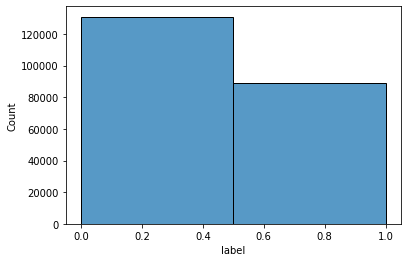

In [2]:
# verify the numbers of entries
print (f'Label entries {len(labels)}, Training files {len([name for name in os.listdir("./train")])}, Test files {len([name for name in os.listdir("./test")])}')
print (labels['label'].value_counts())
sns.histplot(data=labels, x='label', bins=2)

### The data and EDA
The only EDA that does not involve getting into the images is to count the files in the training data set. Among them, 130,908 files are labeled negative and 89,117 files are labeled positive, as shown above. It contains enough positive cases to build a classification model. The number of files matches with the supplied CSV file, and no image file appeared be corrupted. As such, I did not perform any significant data cleansing.

My untrained eyes could not make sense out of visual inspections of images.

### Data Preparation
To take advantage of Kera’s `image_dataset_from_directory()` function, I will copy files to a directory with subdirectories for each class (0 and 1). I will delete and create the directory for each run. Also I will specify the number of files that I use for each run. `image_dataset_from_directory()` takes care of the rest.


In [3]:
DATASETDIR = "./dataset"
NUM_TRAIN_NEGATIVE = 40000
NUM_TRAIN_POSITIVE = 40000

if NUM_TRAIN_NEGATIVE > labels['label'].value_counts()[0] or NUM_TRAIN_POSITIVE > labels['label'].value_counts()[1]:
    print ("Check the sampling number")
    exit()

# Delete files from the precious run
shutil.rmtree(DATASETDIR,ignore_errors=True)  
# Creating the directory structures. Not robust, no error checking, but it should be fine for this product
os.mkdir(DATASETDIR)
os.makedirs(DATASETDIR+"/training/0")
os.makedirs(DATASETDIR+"/training/1")
os.makedirs(DATASETDIR+"/validation/0")
os.makedirs(DATASETDIR+"/validation/1")

# File sampling, randomly
df =pd.concat([labels[labels['label'] == 0].sample(NUM_TRAIN_NEGATIVE, random_state = 13), 
              labels[labels['label'] == 1].sample(NUM_TRAIN_POSITIVE, random_state = 33)], axis=0)
df=shuffle(df).reset_index()

# Split the files into training and validation
X_train, X_test = train_test_split(df, test_size=0.25, random_state=42)

# Copy files 
for i in range(len(X_train)):
    shutil.copyfile("./train/"+X_train.iloc[i]['id']+".tif", 
                    "./dataset/training/"+str(X_train.iloc[i]['label'])+"/"+X_train.iloc[i]['id']+".tif")
    
for i in range(len(X_test)):
    shutil.copyfile("./train/"+X_train.iloc[i]['id']+".tif", 
                    "./dataset/validation/"+str(X_train.iloc[i]['label'])+"/"+X_train.iloc[i]['id']+".tif")


In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_batch_size = 128
test_batch_size = 128

train_steps = np.ceil(len(X_train) / train_batch_size)
test_steps = np.ceil(len(X_test) / test_batch_size)

# the lambda came from: https://forums.fast.ai/t/images-normalization/4058.
gen_data = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True, vertical_flip=True)

train = gen_data.flow_from_directory("./dataset/training",target_size=(96,96),
                                     batch_size=train_batch_size,class_mode='binary')
test = gen_data.flow_from_directory("./dataset/validation",target_size=(96,96),
                                    batch_size=test_batch_size,class_mode='binary')
# use the same validation data for training evaluation too.
val =  gen_data.flow_from_directory("./dataset/validation",target_size=(96,96),
                                    batch_size=1,class_mode='binary',shuffle=False)

Found 60000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


### Model and Architecture
The model is a convolutional neural network model consisting of the input layer, the output layer and the hidden layers. It follows the “typical CNN architecture” that was presented in the lecture, which has the `[Conv->Conv->Maxpool]*n -> Dense -> Out` structure.

The number of filters and layers, as well as the size of filters and poolings are rather rbitrarily chosen. Initially I replicated some structures and parameters that I found in sample programs and notebooks posted on Kaggle. Then I tried combining and tweaking the structures and parameters. The process was highly in try-and-error, and I have to admit that I do not have a solid explanation on why the model responded to my changes in the observed ways. 

For the activation functions, I used ReLU for the hidden layers and Sigmoid for the output layer. I obtained better results with 3x3 MaxPool than 2x2. I applied Dropouts and Batch Normalization for regularization, both of which improved the results. 
I used a Keras function `ReduceLROnPlateau()` which reduces the learning rate when the model performance plateaus. It turned out to be highly effective judging from the command line outputs. 

Finally, the sample size mattered. I started with 2000 to 3000 samples without a GPU, and I was getting the accuracy score of about 0.75 at best. With 80,000 samples from each class, using a GPU, as shown above, I was able to hit 0.85 accuracy.


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import scipy

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 7)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1)

model = Sequential()

# Model definition
# Starting from the structure presented at https://www.kaggle.com/hrmello/cnn-classification-80-accuracy

model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3)) 

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3)) 

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

# Compile and traing the model
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 20
model.fit(train, steps_per_epoch=train_steps, validation_steps=test_steps, validation_data=test,
          epochs=epochs, verbose=1, callbacks = [early_stopping, reducel])

Epoch 1/20
469/469 [==============================] - 257s 523ms/step - loss: 0.4302 - accuracy: 0.8028 - val_loss: 1.4383 - val_accuracy: 0.6055 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 212s 451ms/step - loss: 0.3457 - accuracy: 0.8492 - val_loss: 1.2902 - val_accuracy: 0.5090 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 206s 439ms/step - loss: 0.3140 - accuracy: 0.8647 - val_loss: 0.4182 - val_accuracy: 0.8284 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 217s 462ms/step - loss: 0.2926 - accuracy: 0.8769 - val_loss: 0.5233 - val_accuracy: 0.7757 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 257s 548ms/step - loss: 0.2751 - accuracy: 0.8853 - val_loss: 0.4031 - val_accuracy: 0.8362 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 246s 524ms/step - loss: 0.2565 - accuracy: 0.8938 - val_loss: 0.4001 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 7/20
469/469 [==========================

In [6]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# for to be deprecated functions, specifically predict_generator here.
import warnings
warnings.filterwarnings('ignore')
# make predictions
pred = model.predict_generator(val, steps=len(X_test))
test_accuracy = 100*np.sum(np.round(pred.flatten()).astype('int32')==val.classes)/len(pred)

### Results and Analysis
Since this is a classification problem, I printed the confusion matrix and classification report. I find it rather impressive provided I built the CNN model rather randomly. With more experiences and proper skills, I should be able to achieve better performances. However, for the medical screening model, the recall for the positive class is too low at 0.77. This calls for adjustment.

I observed that adding filters tends to improve the model performance. I wanted to conduct more experiments with more variations, but the computation time was prohibitive in this project. 

As it was sigmoid function at the output, I added a ROC curve below. It shows a nice predictive curve. It suggests that this model already could be useful by choosing the right cut off point, or fine tuning the output activation function.

There still is large room for improvement. Hyperparameters, that are as simple as the epoch count and early stopping patience, can be tuned more. I only tried the minimum combinations of the regularizations and optimizers. 


In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Classificaton report and confusion matrix
b_pred = np.round(pred.flatten())
print('Classification Report\n')
print(classification_report(val.classes,b_pred))
print('Confusion Matrix\n')
print(confusion_matrix(val.classes,b_pred))
print(f'\naccuracy score {accuracy_score(val.classes,b_pred)}')


Classification Report

              precision    recall  f1-score   support

           0       0.81      0.98      0.88      9960
           1       0.97      0.77      0.86     10040

    accuracy                           0.87     20000
   macro avg       0.89      0.87      0.87     20000
weighted avg       0.89      0.87      0.87     20000

Confusion Matrix

[[9756  204]
 [2344 7696]]

accuracy score 0.8726


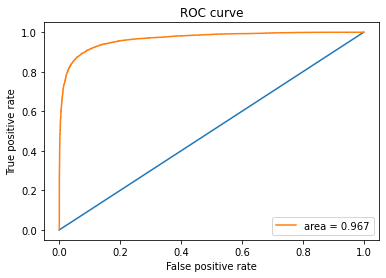

In [36]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# ROC curve

fpr_keras, tpr_keras, thresholds_keras = roc_curve(val.classes, pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1])
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Conclusion

I am satisfied with the outcome of my first deep learning project. Compared with the supervised/unsupervised models that I practiced in the proceeding courses, there are much more hyperparameters and model flexibilities, and the model performance responds well to the changes. If the accuracy is the objective, I found it easier to attain better results with deep learning.

 At the same time, I was not fully confident that I knew what I was doing. While it is fascinating and fun to do, I would not call what I did science or engineering. I need to understand the theory behind the scenes more to apply the techniques in the real world projects. Now I see why people are talking about expandability of the models nowadays.


In [19]:
# Scoring the test images and save the output into the submission file.
# This is ugly and patchy but I could not find a better way to avoid kernel crash.
test_set =  gen_data.flow_from_directory("./test",target_size=(96,96),classes=None,shuffle=False)
scores = model.predict(test_set,verbose=0)
files = [x.split(".")[0] for x in sorted(os.listdir("./test/0"))]
sc = scores.flatten()
submission=pd.DataFrame({'id':files, 'label':sc})
submission.to_csv("submission.csv", index = False, header = True)

Found 57458 images belonging to 1 classes.
